In [54]:
# common imports
import numpy as np
import pandas as pd
import os, cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# global variables
ROWS = 128
COLUMNS = 128
CHANNELS = 3
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 37,500 samples, 25,000 for the training set and 12,500 for the test set.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.

# 1. Getting the Data

In [55]:
train_path = r"dogs-vs-cats\train/"
test_path = r"dogs-vs-cats\test1/"

train_images = [train_path + i for i in os.listdir(train_path)]
test_images = [test_path + i for i in os.listdir(test_path)]
# listdir returns a list with the file names in the given directory

> Note: In order to use the data for ML algorithms the images need to be processed into an array containing the pixel values.
> The following functions do just that:

In [56]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    m = len(images)
    n_x = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_x), dtype=np.uint8)
    y = np.zeros((m, 1))

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        X[i, :] = np.squeeze(image.reshape((n_x, 1)))
        if '/dog' in image_file.lower():
            y[i, 0] = 1
        elif '/cat' in image_file.lower():
            y[i, 0] = 0
        else:
            y[i, 0] = image_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data\n")
    return X, y

In [57]:
X_train, y_train = prep_data(train_images)
X_test, y_test = prep_data(test_images)

Loading: 5000/25000
Loading: 10000/25000
Loading: 15000/25000
Loading: 20000/25000
Loading: 25000/25000
Finished Loading Data

Loading: 5000/12500
Loading: 10000/12500
Loading: 15000/12500
Finished Loading Data



In [58]:
# create a DataFrame including a column for labels
df = pd.concat([pd.DataFrame(y_train, columns=['label']), pd.DataFrame(X_train)], axis=1)
df.head()

,label,0,1,2,3,4,5,6,7,8,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.0,87,164,203,94,171,210,94,171,210,...,2,0,2,2,0,2,2,0,2,2
1,0.0,40,45,40,46,45,41,49,44,41,...,90,42,50,64,29,38,51,26,34,46
2,0.0,45,36,32,26,15,11,43,32,28,...,189,4,192,193,6,188,190,2,169,174
3,0.0,218,223,222,219,224,223,219,224,223,...,219,212,212,214,205,212,215,211,211,217
4,0.0,75,112,140,76,113,141,80,117,145,...,96,68,97,108,61,88,99,56,79,91


In [59]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
#    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()


In [60]:
label_groups = df.groupby('label')

# use groupby to locate instances for each label
sample0 = label_groups.get_group(0)[:3].drop('label', axis = 1)
sample1 = label_groups.get_group(1)[:3].drop('label', axis = 1)

sample_images = pd.concat([sample0, sample1], ignore_index=True)

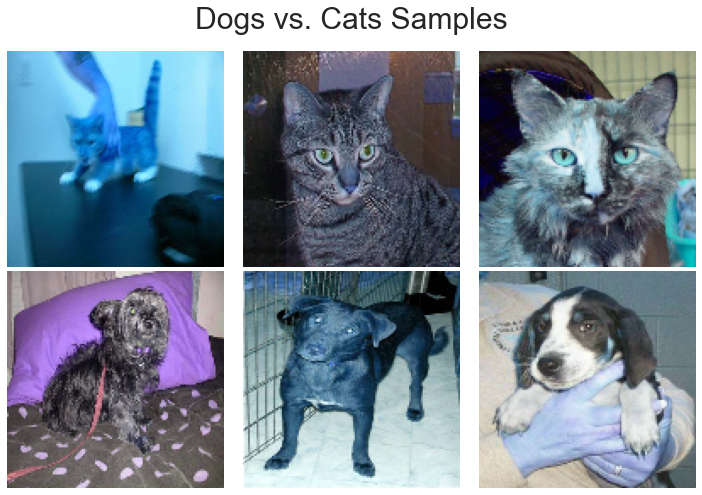

In [61]:
fig = plt.figure(figsize=(10,7))
rows = 2
columns = 3

# add sample image in each iteration
for i in range(rows*columns):
    image = sample_images[i:i+1].to_numpy().reshape((ROWS,COLUMNS, CHANNELS))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.axis('off')
fig.suptitle("Dogs vs. Cats Samples", size=30)
plt.tight_layout()
plt.show()